In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
!unzip /content/drive/MyDrive/FYP/chest_xray_VGG16_Original_Data>.zip -d /content/extracted_files

In [5]:
# Define dataset paths
base_dir = '/content/extracted_files/chest_xray_VGG16_Original_Data'  # Adjust this path as needed
train_dir = os.path.join(base_dir, '/content/extracted_files/chest_xray_VGG16_Original_Data/train')
test_dir = os.path.join(base_dir, '/content/extracted_files/chest_xray_VGG16_Original_Data/test')


In [6]:
# Define data generators without augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)


In [7]:
# Create training and validation datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='binary',
    subset='training'
)


Found 4187 images belonging to 2 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1045 images belonging to 2 classes.


In [9]:
# Create test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [10]:
# Load VGG16 without the top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False


In [12]:
# Build the full model
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [13]:
# Compile the model with a specified learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 591ms/step - accuracy: 0.8601 - loss: 0.6579 - val_accuracy: 0.9703 - val_loss: 0.0864
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 487ms/step - accuracy: 0.9569 - loss: 0.1203 - val_accuracy: 0.9818 - val_loss: 0.0643
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 403ms/step - accuracy: 0.9654 - loss: 0.0951 - val_accuracy: 0.9464 - val_loss: 0.1333
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 396ms/step - accuracy: 0.9746 - loss: 0.0731 - val_accuracy: 0.9799 - val_loss: 0.0529
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 397ms/step - accuracy: 0.9776 - loss: 0.0619 - val_accuracy: 0.9799 - val_loss: 0.0551
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 393ms/step - accuracy: 0.9781 - loss: 0.0604 - val_accuracy: 0.9809 - val_loss: 0.0529
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 406ms/step - accuracy: 0.9842 - loss: 0.0531 - val_accuracy: 0.9818 - val_loss: 0.0527
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.9824 - loss: 0.0474 - val

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 787ms/step - accuracy: 0.6944 - loss: 1.6187
Test Accuracy: 83.01%


In [16]:
# Predict classes on test data
predictions = (model.predict(test_generator) > 0.5).astype("int32")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step


In [17]:
# Generate Confusion Matrix and Classification Report
print("Confusion Matrix")
print(confusion_matrix(test_generator.classes, predictions))


Confusion Matrix
[[130 104]
 [  2 388]]


In [18]:
print("Classification Report")
print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))


Classification Report
              precision    recall  f1-score   support

      NORMAL       0.98      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



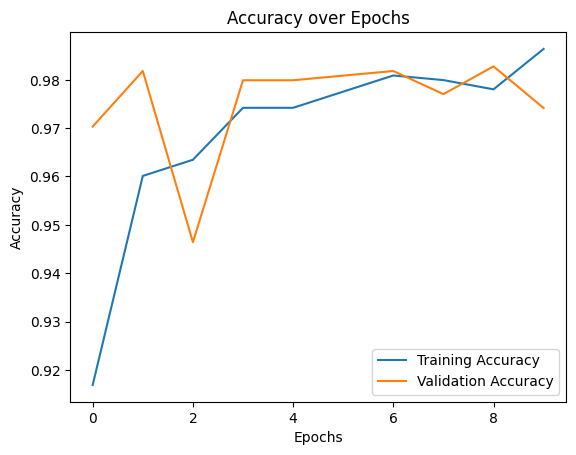

In [19]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


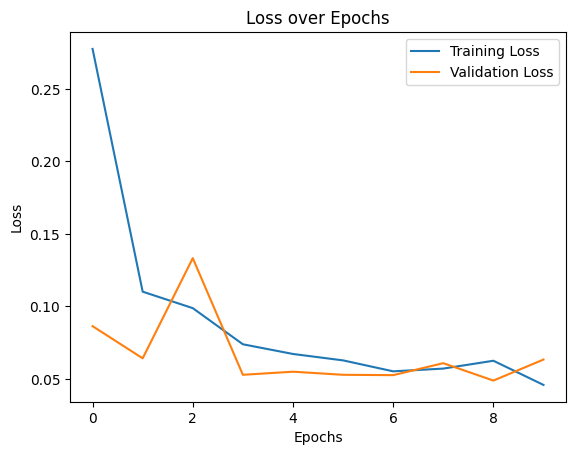

In [20]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
